# Classificação a partir de rostos usando Perceptron Multicamadas

Este *notebook* apresenta o uso do Perceptron Multicamadas para classificação de rostos a partir da base de dados chamada *faces* criada por [Tom Mitchell](http://www.cs.cmu.edu/~tom/) em seu livro *[Machine Learning](http://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/mlbook.html)*, tal base está disponível em [aqui](http://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/faces.html).

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Faces Dataset

Este dataset possui diversas imagens de faces de diversas pessoas, cada pessoa é fotografada em diferentes orientações de cabeça, bem como apresentando diferentes estados de humor, e por fim usando óculos de sol, ou com os olhos abertos. Portanto, é possível termos redes neurais MLP classificar as imagens de acordo com:

* Orientação: cabeça virada para cima, esquerda, direita ou frente.
* Sentimento: triste, alegre, irado ou neutro.
* Olhos: usando óculos de sol ou não.

O dataset é dado em duas versões ambas em formato PGM a saber:

* a primeira versão contém as imagens originais.
* a segunda versão contém as mesmas imagens reduzidas (30x32) pixels.

Neste *notebook* usaremos a segunda versão. A seguir temos o carregamento das imagens:

In [23]:
faces_4_df = pd.read_csv('../Datasets/Faces/faces_4/faces.csv')

In [24]:
faces_4_df.describe()

,Id,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,...,Col950,Col951,Col952,Col953,Col954,Col955,Col956,Col957,Col958,Col959
count,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,208.500000,10.0,28.583732,31.191388,31.555024,31.019139,31.751196,29.437799,28.617225,27.129187,...,72.444976,69.772727,69.813397,70.483254,71.303828,69.672249,67.251196,64.354067,53.619617,32.535885
std,120.810458,0.0,13.472022,10.650620,8.576533,8.691053,9.382637,8.262028,9.522755,9.850322,...,41.775787,42.632539,41.999984,42.007319,40.566504,40.979907,41.257937,42.570849,43.047922,25.965110
min,0.000000,10.0,2.000000,7.000000,9.000000,8.000000,7.000000,6.000000,5.000000,5.000000,...,1.000000,3.000000,1.000000,4.000000,6.000000,5.000000,3.000000,0.000000,0.000000,0.000000
25%,104.250000,10.0,19.000000,25.250000,24.000000,26.000000,27.000000,25.000000,23.000000,21.000000,...,27.000000,26.000000,26.000000,24.000000,30.000000,24.000000,25.000000,24.000000,16.000000,12.250000
50%,208.500000,10.0,28.000000,33.000000,32.000000,31.000000,30.000000,28.000000,27.000000,25.000000,...,84.000000,73.000000,79.500000,82.000000,79.500000,77.500000,70.000000,56.500000,45.000000,28.500000
75%,312.750000,10.0,38.000000,37.000000,39.000000,37.000000,37.000000,35.000000,33.000000,31.000000,...,112.000000,112.000000,112.000000,111.000000,113.000000,112.000000,110.000000,109.000000,97.000000,45.000000
max,417.000000,10.0,53.000000,64.000000,55.000000,60.000000,58.000000,54.000000,53.000000,52.000000,...,138.000000,138.000000,138.000000,137.000000,137.000000,133.000000,135.000000,135.000000,135.000000,128.000000


São 418 instâncias formadas por 964 colunas formadas pelo Id, vetor de pixels (matriz (30x32) vetorizada (960)) e 
3 colunas uma para cada classe (Orientação, Sentimento, Olhos).

In [25]:
faces_4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Columns: 964 entries, Id to Eyes
dtypes: int64(961), object(3)
memory usage: 3.1+ MB


In [26]:
def plot_as_figure(matpixels,ax=None):
    if ax == None:
        plt.imshow(matpixels,plt.cm.gray)
    else:
        ax.imshow(matpixels,plt.cm.gray)

## Exemplo de imagens no dataset

A seguir temos a exibição das quatro primeiras imagens a partir do dataset. É possível verificar que as imagens possuem baixa resolução.

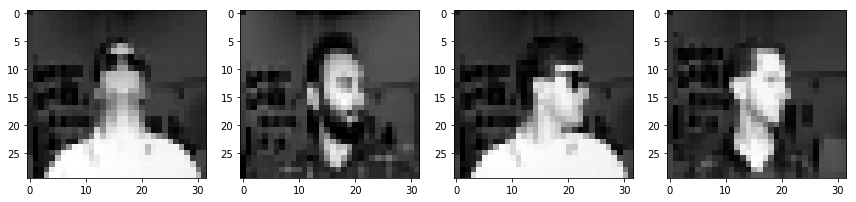

In [27]:
# simple data array plot, just for verification
fig, ax = plt.subplots(1,4,figsize=(12,12))
for i in range(4):
    plot_as_figure(faces_4_df.drop(['Id','Orientation','Sentiment','Eyes'],axis=1).values[i].reshape((30,32)),ax[i])
fig.tight_layout()

## Distribuição entre as classes

A seguir temos a distribuição entre os valores de cada classe, a qual mostra equilibrio na distribuição de valores entre classes.

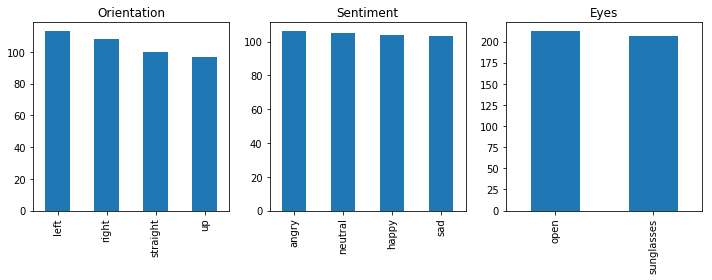

In [28]:
# distribution over classes
fig, ax = plt.subplots(1,3,figsize=(10,4))
faces_4_df.Orientation.value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Orientation')
faces_4_df.Sentiment.value_counts().plot.bar(ax=ax[1])
ax[1].set_title('Sentiment')
faces_4_df.Eyes.value_counts().plot.bar(ax=ax[2])
ax[2].set_title('Eyes')
fig.tight_layout()
plt.show()

## Pre-processamento

### Binarização das classes

Uma vez que desejamos treinar **MLP**'s para classificação e tais modelos apenas conseguem trabalhar com dados numéricos, as classes presentes devem passar por um pré-processamento, pois possuem valores categóricos, i. e., a classe **Orientação** possui os seguintes valores categóricos **left**, **right**, **straight** e **up**.

Sendo assim, cada classe será binarizada, ou seja, seus valores serão transformados em colunas contendo (0,1) nesse caso, onde 0 indica que a instância não foi classificada com o dado valor em questão e 1 caso contrário.

In [29]:
from sklearn.preprocessing import LabelBinarizer

#### Binarizando a classe Orientation

Apresentando valores a serem binarizados, e a binarização das 10 primeiras instâncias.

In [30]:
# binarizing classes for Orientation
enc = LabelBinarizer()
y_orientation = enc.fit_transform(faces_4_df.Orientation.values)
orientarion_classes = enc.classes_
print(orientarion_classes)
print(y_orientation[0:10])

['left' 'right' 'straight' 'up']
[[0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]]


#### Binarizando a classe Sentiment

Apresentando valores a serem binarizados, e a binarização das 10 primeiras instâncias.

In [31]:
# binarizing classes for Sentiment
enc = LabelBinarizer()
y_sentiment = enc.fit_transform(faces_4_df.Sentiment.values)
sentiment_classes = enc.classes_
print(sentiment_classes)
print(y_sentiment[0:10])

['angry' 'happy' 'neutral' 'sad']
[[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]]


#### Binarizando a classe Eye

Apresentando valores a serem binarizados, e a binarização das 10 primeiras instâncias.

In [32]:
# binarizing classes for Eyes
enc = LabelBinarizer()
y_eyes = enc.fit_transform(faces_4_df.Eyes.values).reshape(418)
eyes_classes = enc.classes_
print(eyes_classes)
print(y_eyes[0:10])

['open' 'sunglasses']
[1 0 1 0 1 1 0 0 0 0]


#### Removendo colunas não utilizadas

A coluna **Id** não é utilizada para fins de classificação, além disso as colunas de classe (**Orientation**, **Sentiment**, **Eye**) também foram removidas para a criação do *dateset* de entrada.

In [33]:
# X dataset
X = faces_4_df.drop(['Id','Orientation','Sentiment','Eyes'],axis=1).values

## Treinamento de uma MLP

Inicialmente desejamos verificar o comportamento prévio de um classificador MLP com relação à base de dados preparada 
a partir do preprocessamento realizado anteriormente. Para isto vamos criar 3 classificadores MLP, um para cada classificação (**Orientação**, **Sentiment**, **Eyes**) e avalia-los separadamente.

A configuração arbitrária de cada MLP é:
* Camada oculta: 1 contendo 200 neurônios
* Método de otimização (Solver): SGD
* Função de ativação: ReLU (**Re**ctified **L**inear **U**nit) $$ y=max(0,x) $$
* Tolerância: $$ 10^{-9} $$, treinamento para se erro não diminuir mais que a tolerância.
* Máximo de epócas: 500.

```python
MLPClassifier(hidden_layer_sizes=(200,),solver='sgd',activation='relu',verbose=verbose,tol=1e-9,max_iter=500)
```

O treinamento é feito a partir de um simples *train/test split* tendo o conjunto de testes 20% do total de instâncias.

```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
```

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.neural_network import MLPClassifier

In [36]:
def evolve_NN(X,y,name,randon_state=0,verbose=False,label_names=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    clf = MLPClassifier(hidden_layer_sizes=(200,),solver='sgd',activation='relu',verbose=verbose,tol=1e-9,max_iter=500)
    clf.fit(X=X_train,y=y_train)
    fig, (ax, ax1) = plt.subplots(1,2,figsize=(10,6))
    ax.plot(np.array(clf.loss_curve_))
    ax.set_title('Training error - MLP for '+name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error")
    y_pred = clf.predict(X_test)
    error_test = sum(abs(y_pred-y_test))/len(y_pred)
    print("Test error ",name,":",error_test)
    width=0.5
    if isinstance(error_test,float):
        ax1.bar(np.arange(1),[error_test],width)
        ax1.set_xticks(np.arange(1) + width // 2)
    else:
        ax1.bar(np.arange(len(error_test)),error_test,width)
        ax1.set_xticks(np.arange(len(error_test)) + width // 2)
    ax1.set_ylabel('Error')
    ax1.set_title('Test Error - '+name)
    ax1.set_ylim([0,1])
    ax1.set_xticklabels(label_names)
    fig.tight_layout()
    return {'X': {'train': X_train, 'test': X_test}, 'y': {'train': y_train, 'test': y_test}, 'clf': clf, 'y_pred': y_pred}

### Treinamento da MLP - Eyes

Test error  Eyes : 0.214285714286


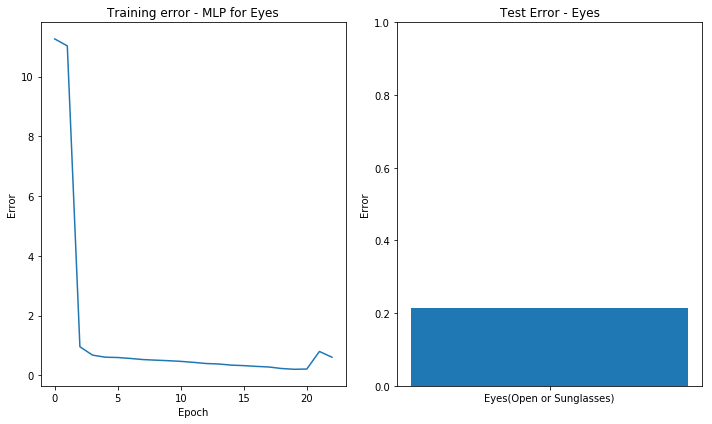

In [37]:
# NN for Eyes Classification
eval_Eyes = evolve_NN(X=X,y=y_eyes,name='Eyes',label_names=['Eyes(Open or Sunglasses)'])

### Treinamento MLP - Sentiment

Test error  Sentiment : [ 0.26190476  0.28571429  0.30952381  0.17857143]


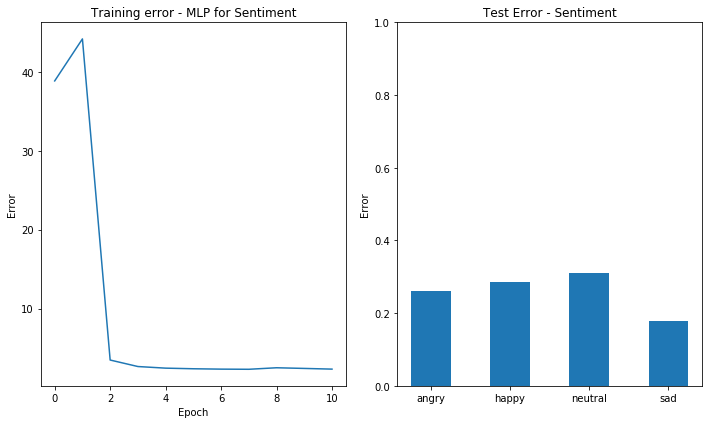

In [38]:
# NN for Sentiment
eval_Sentiment = evolve_NN(X=X,y=y_sentiment,name='Sentiment',label_names=sentiment_classes)

Test error  Orientation : [ 0.27380952  0.11904762  0.19047619  0.19047619]


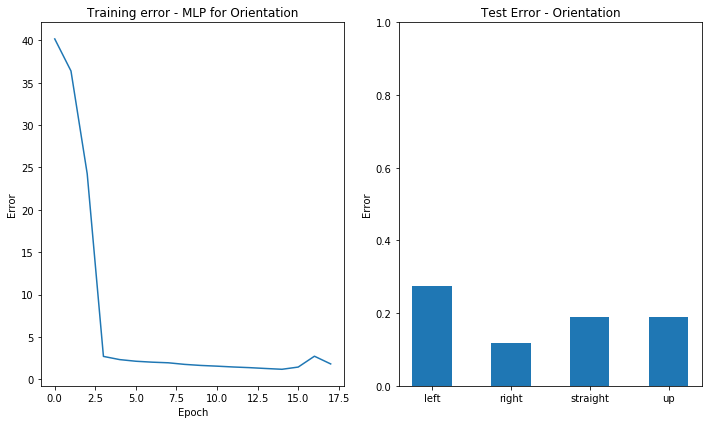

In [39]:
# NN for Orientarion
eval_Orientation = evolve_NN(X=X,y=y_orientation,name='Orientation',label_names=orientarion_classes)